Homework 2: 使用GPU執行AI程式來分類狗跟貓，並顯示各種衡量參數
1.先使用教材的資料將具有GPU顯卡的電腦環境設定好
2.將Tensorflow安裝好
3.尋找具有貓跟狗的dataset，這個dataset也有貓跟狗的bounding及labelling資訊。Ex: https://www.microsoft.com/en-us/download/details.aspx?id=54765
4.去網路上(ex: GitHub)先找到現成的AI model source code，如Basic CNN、VGG16、VGG19、MobileNetV2、Faster R-CNN等等，先確定它是正確且可以執行的，請每個人跑的AI model都不一樣，一來可以獨自練習，二來也可以互相比較效能
5.開始跑AI model，請使用10-fold cross-validation來驗證，也就是說要跑10次，最後計算這10次的平均值，要跑的衡量參數有Accuracy、Loss、Sensitivity、Specificity、Precision、Recall、F1-score、AUC。請做成表格來填寫比較，到這邊就算完成作業了
6.如果行有餘力，可以自行修改AI model，重跑步驟5，看看效果有沒比較好?
7.如果行有餘力，可以做資料擴增，重跑步驟5，看看效果有沒比較好?
8.如果行有餘力，可以影像前處理，重跑步驟5，看看效果有沒比較好?
9.如果行有餘力，可以加入bounding功能，如果行有餘力，重跑步驟5，看看效果有沒比較好?

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, models, layers, utils, activations, losses, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import tensorflow_datasets as tfd 載入失敗 下載應該就掛了
from glob import glob
from tqdm import tqdm
import cv2
import os 
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
#兩類 dog & cat
num_classes = 2
IMG_SIZE =  128

In [3]:
paths_cat = glob('PetImages\Cat2\*.jpg')
paths_dog = glob('PetImages\Dog2\*.jpg')
len(paths_cat),len(paths_dog)

(1716, 2002)

In [4]:
all_path = paths_cat + paths_dog
random.shuffle(all_path) #打亂排序

PetImages\Cat2\1636.jpg


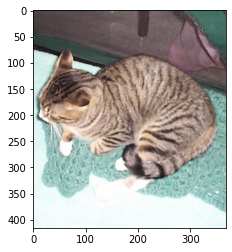

In [5]:
idx = 5
path = all_path[idx]
img = cv2.imread(path)[:,:,::-1]
plt.imshow(img)
print(path)

In [6]:
#split dataset
train_data, test_data = train_test_split(all_path, test_size=0.3)
train_data, val_data = train_test_split(train_data, test_size=0.3)


len(train_data),len(test_data),len(val_data)

(1821, 1116, 781)

In [7]:
def create_dataset(paths, img_size=IMG_SIZE, num_classes=num_classes, test=False):
    num_data = len(paths)
    x_data = np.empty((num_data, img_size, img_size, 3))
    y_data = np.empty((num_data))

    for i,path in enumerate(tqdm(paths)):
        try:
            img = cv2.imread(path)[:,:,::-1]
            img = cv2.resize(img, (img_size, img_size))
            img = img/255.
            x_data[i] = img

            if test is False:
                filename = os.path.split(path)[0]
                if filename == 'PetImages\Cat2':
                    y_data[i] = 0
                else:
                    y_data[i] = 1
                    
        except:
            continue
    if not test:
        y_data = utils.to_categorical(y_data, num_classes=num_classes)
        return x_data, y_data
    else:
        return x_data

In [8]:
x_train, y_train = create_dataset(train_data)
x_val, y_val = create_dataset(val_data)
x_test = create_dataset(test_data, test = True)

100%|█████████████████████████████████████████████████████████████████████████████| 1116/1116 [00:03<00:00, 283.81it/s]


In [13]:
len(x_train),len(y_train)
len(x_val),len(y_val)
len(x_test)

1116

In [9]:
print(y_train)

[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [22]:
model2 = models.Sequential([layers.Dense(units=128,activation='relu',input_shape=(IMG_SIZE*IMG_SIZE,)),
              layers.Dense(units=128),
              layers.Dense(units=256),
              layers.Dense(units=256),
              layers.Activation('relu'),
              layers.Dense(num_classes,activation='softmax')])

In [27]:
# GoogLeNet / InceptionV1
def inception(x, nb_filter):
    branch1x1 = layers.Conv2D(nb_filter, (1,1), padding='same', activation='relu')(x)

    branch3x3 = layers.Conv2D(nb_filter, (1,1), padding='same', activation='relu')(x)
    branch3x3 = layers.Conv2D(nb_filter, (3,3), padding='same', activation='relu')(branch3x3)

    branch5x5 = layers.Conv2D(nb_filter, (1,1), padding='same', activation='relu')(x)
    branch5x5 = layers.Conv2D(nb_filter, (5,5), padding='same', activation='relu')(branch5x5)

    branchpool = layers.MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(x)
    branchpool = layers.Conv2D(nb_filter, (1,1), padding='same', activation='relu')(branchpool)

    x = layers.concatenate([branch1x1, branch3x3, branch5x5, branchpool], axis=-1)

    return x

In [21]:
inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
x = layers.Conv2D(64, (7,7), padding='same', strides=(2,2), activation='relu')(inputs)
x = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = layers.Conv2D(192, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = inception(x,64)
x = inception(x,120)
x = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = inception(x,128)
x = inception(x,128)
x = inception(x,132)
x = inception(x,208)
x = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = inception(x,208)
x = inception(x,256)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, x)

NameError: name 'inception' is not defined

In [23]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               2097280   
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 dense_12 (Dense)            (None, 256)               33024     
                                                                 
 dense_13 (Dense)            (None, 256)               65792     
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 2)                 514       
                                                                 
Total params: 2,213,122
Trainable params: 2,213,122
No

In [24]:
model2.compile(loss=losses.categorical_crossentropy,
       optimizer='Adam',
       metrics=['accuracy']
       )

In [25]:
logs = model2.fit(x_train, y_train,
                 batch_size=32,
                 epochs=20,
                 validation_data=(x_val, y_val))

Epoch 1/20


ValueError: in user code:

    File "C:\Users\88691\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\88691\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\88691\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\88691\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\88691\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\88691\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 16384), found shape=(None, 128, 128, 3)


In [42]:
model.compile(loss=losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])#metrics=[metrics.categorical_accuracy]

In [43]:
logs = model.fit(x_train, y_train,
                 batch_size=32,
                 epochs=20,
                 validation_data=(x_val, y_val))

Epoch 1/20
57/57 [==============================] - 7s 73ms/step - loss: 0.6873 - accuracy: 0.5552 - val_loss: 0.6884 - val_accuracy: 0.5493
Epoch 2/20
57/57 [==============================] - 4s 64ms/step - loss: 0.6874 - accuracy: 0.5552 - val_loss: 0.6883 - val_accuracy: 0.5493
Epoch 3/20
57/57 [==============================] - 4s 64ms/step - loss: 0.6874 - accuracy: 0.5552 - val_loss: 0.6883 - val_accuracy: 0.5493
Epoch 4/20
57/57 [==============================] - 4s 64ms/step - loss: 0.6873 - accuracy: 0.5552 - val_loss: 0.6886 - val_accuracy: 0.5493
Epoch 5/20
57/57 [==============================] - 4s 64ms/step - loss: 0.6873 - accuracy: 0.5552 - val_loss: 0.6883 - val_accuracy: 0.5493
Epoch 6/20
57/57 [==============================] - 4s 64ms/step - loss: 0.6875 - accuracy: 0.5552 - val_loss: 0.6885 - val_accuracy: 0.5493
Epoch 7/20
57/57 [==============================] - 4s 64ms/step - loss: 0.6877 - accuracy: 0.5552 - val_loss: 0.6884 - val_accuracy: 0.5493
Epoch 8/20
57

In [44]:
#Training logs
history = logs.history

In [45]:
min_loss_epoch = np.argmin(history['val_loss'])
print('min_loss_epoch: ', min_loss_epoch)
print('val loss ', history['val_loss'][min_loss_epoch])
print('val acc', history['val_accuracy'][min_loss_epoch])

min_loss_epoch:  4
val loss  0.6882848739624023
val acc 0.5492957830429077


Text(0.5, 1.0, 'accuracy')

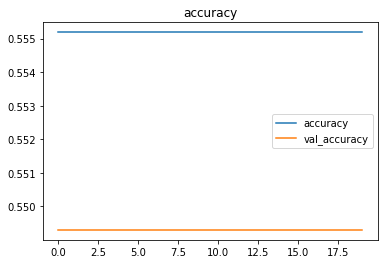

In [46]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('accuracy')

Text(0.5, 1.0, 'loss')

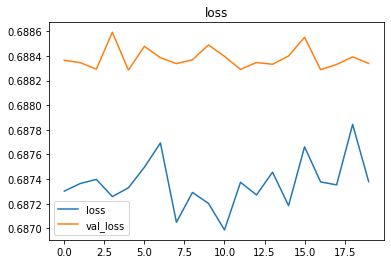

In [47]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

In [48]:
predictions = np.argmax(model.predict(x_test), axis=-1)

df = pd.DataFrame()
df['Id'] = [p.split(os.sep)[-1] for p in test_data]
df['Category'] = predictions
df.to_csv('submission.csv', index=None)
df

35/35 [==============================] - 1s 19ms/step


,Id,Category
0,234.jpg,1
1,1563.jpg,1
2,1163.jpg,1
3,1298.jpg,1
4,460.jpg,1
...,...,...
1111,498.jpg,1
1112,1185.jpg,1
1113,1107.jpg,1
1114,753.jpg,1
